## Spring Board 7.2:

## 2017 Impacts of Violence in Nepal Highly Correlated with Population and Elections

The Nepal Monitor Project (NepalMonitor.org) comprehensively maps human rights and violence data
across Nepal using the vast majority of national news sources. The embedded Peace
Monitoring Project sends local sources in from 20+ districts to have all incidents of violence
systematically mapped, with the goal of improving understanding of violence in Nepal to
better respond to it and promote peace. This project started half way though 2016, making 2017 the first complete year NepalMonitor can claim to have a comprehensive record of all violence appearing in Nepali Media. 

In this initial exploration, I set out to answer some simple questions, with an eye toward evaluating the dataset's use for further analysis. Given that the data is collected systematically and thorougly, the expected answer to these questions would be yes. 

- Are the impacts of violence in the data coorelated with specific events?
- Are they correlated with population and/or with each other?
- Are there significant differences in trends between provinces that can be shown?

## Data Preparation
The Nepal Monitor data set contains more than a hundred different category tags, and categorizes the actors and inferred causes of violence in detail. It also counts the impacts of each violent incident. 

1. As impact data is already qualitative, it is the lowest hanging fruit for analysis.  The first step after cleaning the dataset was to seperate out the impacts.

2. Next was to create a dataframe to plot impacts by date.

3. Finally, was to create a dataframe to plot impacts by district, and combine that with 2011 population satistics and province number. Federal provinces in Nepal were newly created in 2017 as a result of a post conflict process, and will only have numbers until each Federal unit decides on a name.

In [1]:
#Import Main Data Frame
import pandas as pd
import numpy as np

cleanpath='Data/NM_2016_17clean.csv'
df = pd.read_csv(cleanpath)

#print(df.shape[0],'x',df.shape[1])
#df.columns

In [2]:
# convert 'INCIDENT DATE' column to date time objects
df['INCIDENT DATE'] = pd.to_datetime(df['INCIDENT DATE'])

In [3]:
## Create a dataframe for plotting impacts
#Drop out irrelivant frames
impactsdroplist = ['Peace Monitoring - General Information','INCIDENT TITLE', 'LOCATION', 'INCIDENT NUMBER', 
       'DESCRIPTION',  'Development Region', 'Zone','SOURCE', 'SOURCE TYPE',
       'Municipality/VDC', 'Ward', 'District(New)', 'Municipality/VDC(New)',
       'Ward(New)',
       'Event Date - Peace Monitoring','LATITUDE', 'LONGITUDE','CATEGORY',
       'Duration - only applicable to non-violent forms', 'Number of Injuries',
       'Violent vs non-violent', 'One-sided vs two-sided', 'Number of Deaths',
       'Collective vs interpersonal', 'Forms and Causes',
       'Event form - primary', 'Event form - secondary', 'Weapon', 'Weapon 2',
       'Cause - primary', 'Cause - secondary', 'Crosscutting issues',
       'Actor 1 - Perpetrator', 'Actor 1 - Number of People',
       'Actor 1 - Perpetrator Type', 'Actor 1 Entity Name',
       'Actor 1 - Youth -25 years or below- involvement',
       'Actor 2 - Perpetrator 2 or Target', 'Actor 2 Numbers',
       'Target - if one-sided violence',
       'Perpetrator 2 - if two-sided violence', 'Actor 2 entity name',
       'Actor 2 - Youth -25 years or below- involvement', 'Impacts','Election-related specific cause secondary', 'Verification Feedback',
       'VERIFIED']
impactsdf = df.drop(impactsdroplist,axis=1)

#We will only sort by district, so incidents with a lower location acurracy should be dropped.
ss = 'LOCATION ACCURACY'
#imask = ss[(ss == 'Zone') or (ss == 'Country') or (ss == 'Development Region')]
impactsdf = impactsdf[impactsdf[ss] != 'Zone']
impactsdf = impactsdf[impactsdf[ss] != 'Country']
impactsdf = impactsdf[impactsdf[ss] != 'Development Region']

#impactsdf.head()

In [4]:
#Create a dataframe for plotting impacts by Date
#Stats were not logged until midway through 2016. Let's remove 2017
impactsdf.index  = impactsdf['INCIDENT DATE']
impactsdf = impactsdf['2017']
#impactsdf = impactsdf.sort_index()

#group and sum up df
#imdist = impactsdf.groupby(['District']).sum()

imdate = impactsdf.groupby(['INCIDENT DATE']).sum()

#drop out values where these stats were not being recorded
imdate.dropna(axis=0,inplace=True)

imdate = imdate.sort_index()



#imdate = imdate['2017']

#imdate.head()


/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 'INCIDENT DATE' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.


In [5]:
#Create Dateaframe for plotting impacts by district

imdist = impactsdf.groupby(['District']).sum()
#imdist.head()

In [6]:
#Combine disticts data frame with province and population data
pop_pd = pd.read_csv('Data/District_Province_Population')
pop_pd = pop_pd.set_index('District')
pop_pd = pop_pd.sort_index()
#pop_pd.head()

In [7]:
#Test if district names are correct - Prints out the districts that don't match. 
for num in range(75):
    test = imdist.index[num] == pop_pd.index[num]
    if test == False:
        print(pop_pd.index[num],imdist.index[num])

In [8]:
#Put the Province in the index and take a look. 
imdist_pop = pop_pd.join(imdist)
#imdist_pop = imdist_pop.sort_by('Province')
#imdist_pop = imdist_pop.set_index(['Province','District'])
#imdist_pop.head()

## Are the impacts of violence in the data coorelated with specific events?

In 2017, Nepal experienced 3 rounds of elections for new local bodies (created by combining diffent wards together), and 1 combined round of elections for the House of Representatives and officials at the provincial level. The decision making process for the creation of all these units was highly contested, and resulted in multiple rounds of strikes and protests, begining with the registration process. 

These time periods can be highlighted while ploting impacts in a time series to find if there are any notable correlations. 

In [9]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

#We can do better than that... Agrigate by week / month --- create as function.
imweek = imdate.resample('W').sum()
immonth = imdate.resample('M').sum()
#try it with plotly - Not working
#import plotly
#plotly.offline.init_notebook_mode(connected=True)
#import plotly.offline as pyo


def dc(m,d):
    return dt.datetime(2017,m,d)
    
def adddates(Range,df,ann):
#Create background colors and annotations based on time spans
    dtdict = {}
    begin = dc(2,20)
    end = dc(5,1)
    dtdict['Local Registration'] = [begin,end,'blue',0.05]
    begin = dc(5,2)
    end = dc(5,21)
    dtdict['1st Local'] = [begin,end,'blue',0.1]
    begin = dc(6,18)
    end = dc(7,5)
    dtdict['2nd Local'] = [begin,end,'blue',0.1]
    begin = dc(9,6)
    end = dc(9,25)
    dtdict['3rd local'] = [begin,end,'blue',0.1]
    begin = dc(9,24)
    end = dc(12,14)
    dtdict['HoR / Provincial'] = [begin, end, 'blue',0.05]
    #if ann == True:
    ymin, ymax = plt.ylim()
    xoffset = 0        
    for span in dtdict:  
        begin = dtdict[span][0]
        end = dtdict[span][1]
        c = dtdict[span][2]
        a = dtdict[span][3]
        for spn in dtdict:
            thatdate = dtdict[spn][0]
            if begin.month == thatdate.month: #(abs(othertop - top) < 3) and
                    #print(begin.month)
                days = begin.day - thatdate.day
                if days < 20 and days > 0:
                    xoffset = days * 2
                    #print(span, days, xoffset)
                #print(ymax, top)
        plt.axvspan(begin, end, color=c, alpha=a*2)
        if ann == True:
            plt.annotate(span, xy=(begin, ymax), xytext=(xoffset,3), textcoords='offset points', fontsize='x-large',color=c, alpha=a+0.5)
            
#plot killed and injured
def plotimpact(Range,title,interval,df,ann):
    #plt.figure(figsize=(11.69, 4.125))
    top=0
    for impact in Range:
        plt.plot(impact, data=df)
    
    elstr = ''
    adddates(Range,df,ann)
    elstr = ' - Election Rounds Highlighted'
    #plt.xlabel('Month')
    #plt.ylabel(interval + 'ly Total')
    #plt.title(title + ' ' + interval + elstr)
    plt.yticks(fontsize='large')
    plt.legend(loc='best', fontsize='medium')
    sns.despine()    
    #plt.show()


def fullrun(interval, df, cats, ann):
    imps=df.columns
    if 'Killed' in cats:
        plotimpact(imps[0:3],'Total Killed by',interval,df,ann)
    if 'Injured' in cats:
        plotimpact(imps[3:5],'Total Injured by', interval,df,ann)
    if 'Rapes' in cats:
        plotimpact(imps[5:8],'Total Rapes by', interval,df,ann)
    if 'Abductions' in cats:
        plotimpact(imps[8:11],'Total Abductions by', interval,df,ann)
    if 'Physical' in cats: 
        plotimpact(imps[11:],'Physical Damage by', interval,df,ann)

#fullrun('Week', imweek)
#fullrun('Month', immonth)

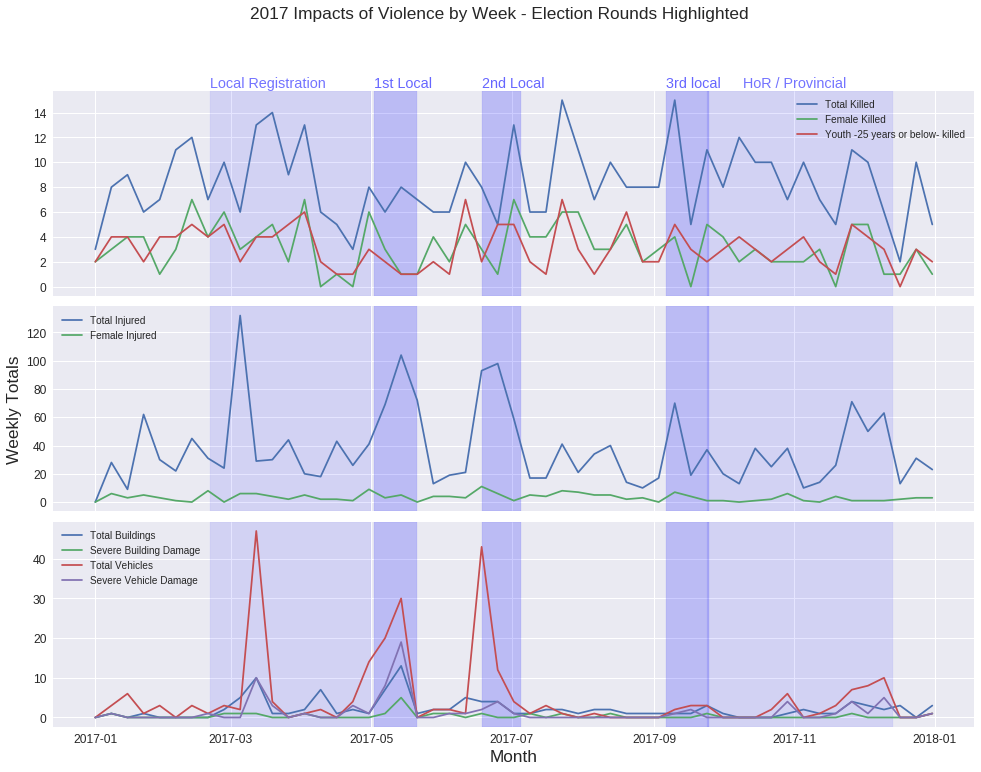

In [11]:
A3 = (16.5,11.7)
A4 = (11.7,8.3)
fig, ax = plt.subplots(3,1, sharex=True, figsize=A3)

fig.subplots_adjust(hspace=.05)
plt.style.use('seaborn')
fig.suptitle('2017 Impacts of Violence by Week - Election Rounds Highlighted',fontsize='xx-large')

plt.axes(ax[0])



fullrun('Week', imweek,['Killed'],True)
#plt.show()
#plt.figure(figsize=(16, 4.25))
plt.axes(ax[1])
fullrun('Week', imweek,['Injured'],False)
plt.ylabel('Weekly Totals', fontsize='xx-large')
plt.axes(ax[2])
fullrun('Week', imweek,['Physical'],False)
plt.xlabel('Month', fontsize='xx-large')
plt.xticks(fontsize='large')
for x in range(2):
    plt.setp(ax[x].get_xticklabels(), visible=False)

plt.show()

It is immediately apparent that, while there is no obvious correlation between election rounds and the total number of people killed per week, there is a striking relationship between the total number of injured and the timing of the elections. Interestingly, the spikes in the total number of injured are not reflected in the number of 'Female Injured.' This can either be attributed to an exclusively male participation in election related contestation, or an inability to differentiate gender among injured in media reports. Reports of physical damage to buildings and vehicles similarly match the timing of election rounds


## Are impacts of violence correlated with population and/or with each other?

In [25]:
# Calculate overall homicide rate. 
tkilled = imdist_pop['Total Killed'].sum()
tpop = imdist_pop['Population'].sum()

print(' Total Killed:', int(tkilled),'\n'\
      ,'Population:',int(tpop),'\n'\
      , 'Homicide Rate Per 100,000:', round(tkilled/(tpop/100000),2))

 Total Killed: 442 
 Population: 26252883 
 Homicide Rate Per 100,000: 1.68


Simply dividing the sum of the Total Killed by the sum of the population per district (divided by 100,000) yeilds a homicide rate of about 1.68 per 100,000 people. This can be used as a sanity check for subsequent figures.


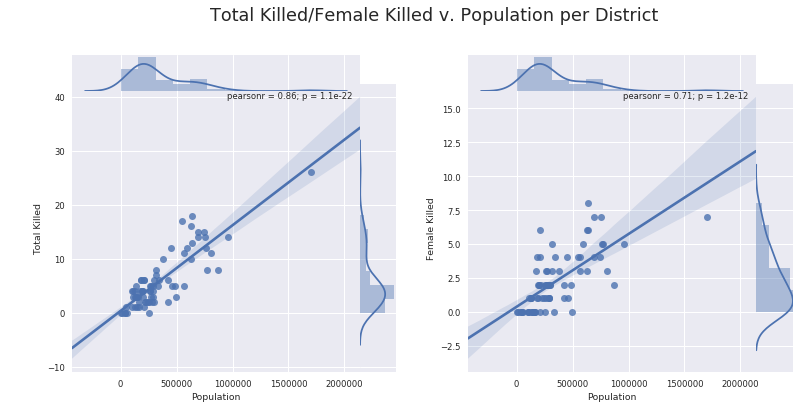

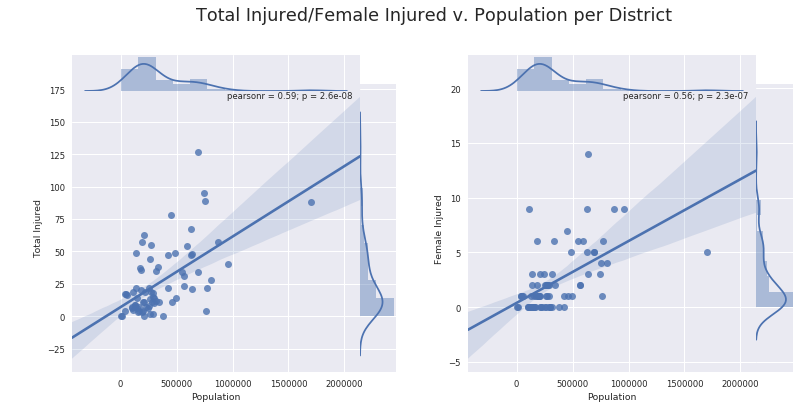

In [52]:
#Create jointplots of impacts v. population. 
import seaborn as sns


def plot2joints(y1,y2):

    #plot 2 jointplots 
    sns.set(font_scale=0.85)
    JG1 = sns.jointplot(x='Population', y=y1, data=imdist_pop, kind='reg', size=10)
    plt.close()
    JG2 = sns.jointplot(x='Population', y=y2, data=imdist_pop, kind='reg', size=10)
    plt.close()
    
    
    #subplots migration
    f = plt.figure()
    #fig.set_size_inches(16,8)
    for J in [JG1, JG2]:
        for A in J.fig.axes:
            f._axstack.add(f._make_key(A), A)
    
    
    #subplots size adjustment
    f.axes[0].set_position([0.1, 0.06, 0.4,  0.4])
    f.axes[1].set_position([0.1, 0.45, 0.4,  0.05])
    f.axes[2].set_position([0.5, 0.06, 0.05, 0.4])
    f.axes[3].set_position([0.65, 0.06, 0.4,  0.4])
    f.axes[4].set_position([0.65, 0.45, 0.4,  0.05])
    f.axes[5].set_position([1.05, 0.06, 0.08, 0.4])
    #f.axes.set_size_inches(16,8)
    f.suptitle(y1+'/'+y2+' v. Population per District', x=.8,y=1.05, fontsize='xx-large')
    plt.show()


yl = ['Total Killed', 'Female Killed', 'Total Injured', 'Female Injured']

#plot2joints before we plot2joints
plot2joints(yl[0],yl[1])
#...and then we plot two more. 
plot2joints(yl[2],yl[3])



From the jointplots above, there is an obvious relationship between district population and various impact numbers. For the total killed by population, chart for instance, a "pearsonr = 0.86" shows there is a essentially an 86% linear correlation between Population and 'Total Killed.' In the same graph, "p=1.1e-22" means there is a vanishingly small (1.1 * 10 to the negative 22nd) chance that the null hypothesis (that the relationship is a result of random chance) is correct.

Next we can create an entire dataframe of impacts divided by corresonding district population numbers.

In [53]:
#Normalize df by population 
def normalize(df,per,log):
    df_norm = df
    for district in range(0,df_norm.shape[0]):
        for column in range(1,df_norm.shape[1]):
            impact = df_norm.iloc[district, column]
            pop = df_norm['Population'][district]
            if log == True:
                df_norm.iloc[district, column] = impact/(math.log(pop,20))
            else:
                df_norm.iloc[district, column] = impact/(pop/per) # <- should create no. incidents per this no. population. 
    return df_norm

imdist_pop_no_prov = imdist_pop.drop('Province', axis=1)
imdist_normalized = normalize(imdist_pop_no_prov, 100000, False)

#imdist_normalized.head()


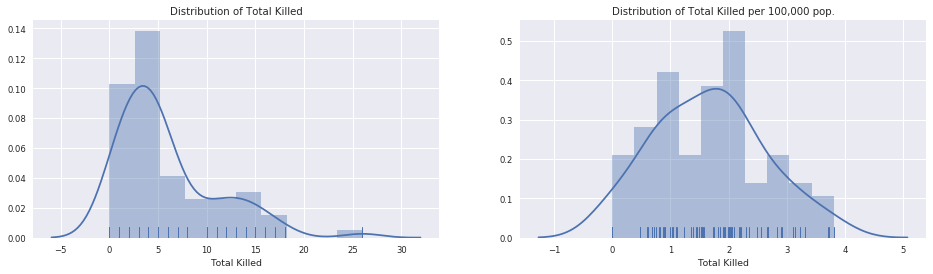

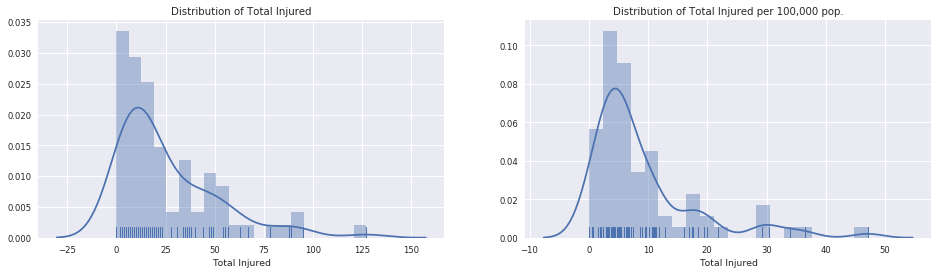

In [15]:
#Create histograms of impacts v impacts per 100,000 pop
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.set_title('Distribution of Total Killed')
ax2.set_title('Distribution of Total Killed per 100,000 pop.')
sns.distplot(imdist_pop['Total Killed'], bins=10, rug=True, ax=ax1)
sns.distplot(imdist_normalized['Total Killed'], bins=10, rug=True, ax=ax2)
sns.despine()
plt.show()

f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.set_title('Distribution of Total Injured')
ax2.set_title('Distribution of Total Injured per 100,000 pop.')
sns.distplot(imdist_pop['Total Injured'], bins=20, rug=True, ax=ax1)
sns.distplot(imdist_normalized['Total Injured'], bins=20, rug=True, ax=ax2)
sns.despine()
plt.show()

The effect of dividing the entire data-frame by population can be seen above.  The histograms in the left show the raw distrobution of 'Total Killed' and 'Total Injured, with their similar skew to the left indicating more districts have lower impact numbers and fewer districts have higher impact numbers. 

The histograms on the right show the same impacts per 100,000 population. While 'normalizing' the 'Total killed' by population creates a more normal (bell shaped) distribution, doing the same to 'Total Injured,' seems to barely changes the shape of the distribution at all. More complex attempts at normalizing the 'Total Injured' numbers remain to be explored.

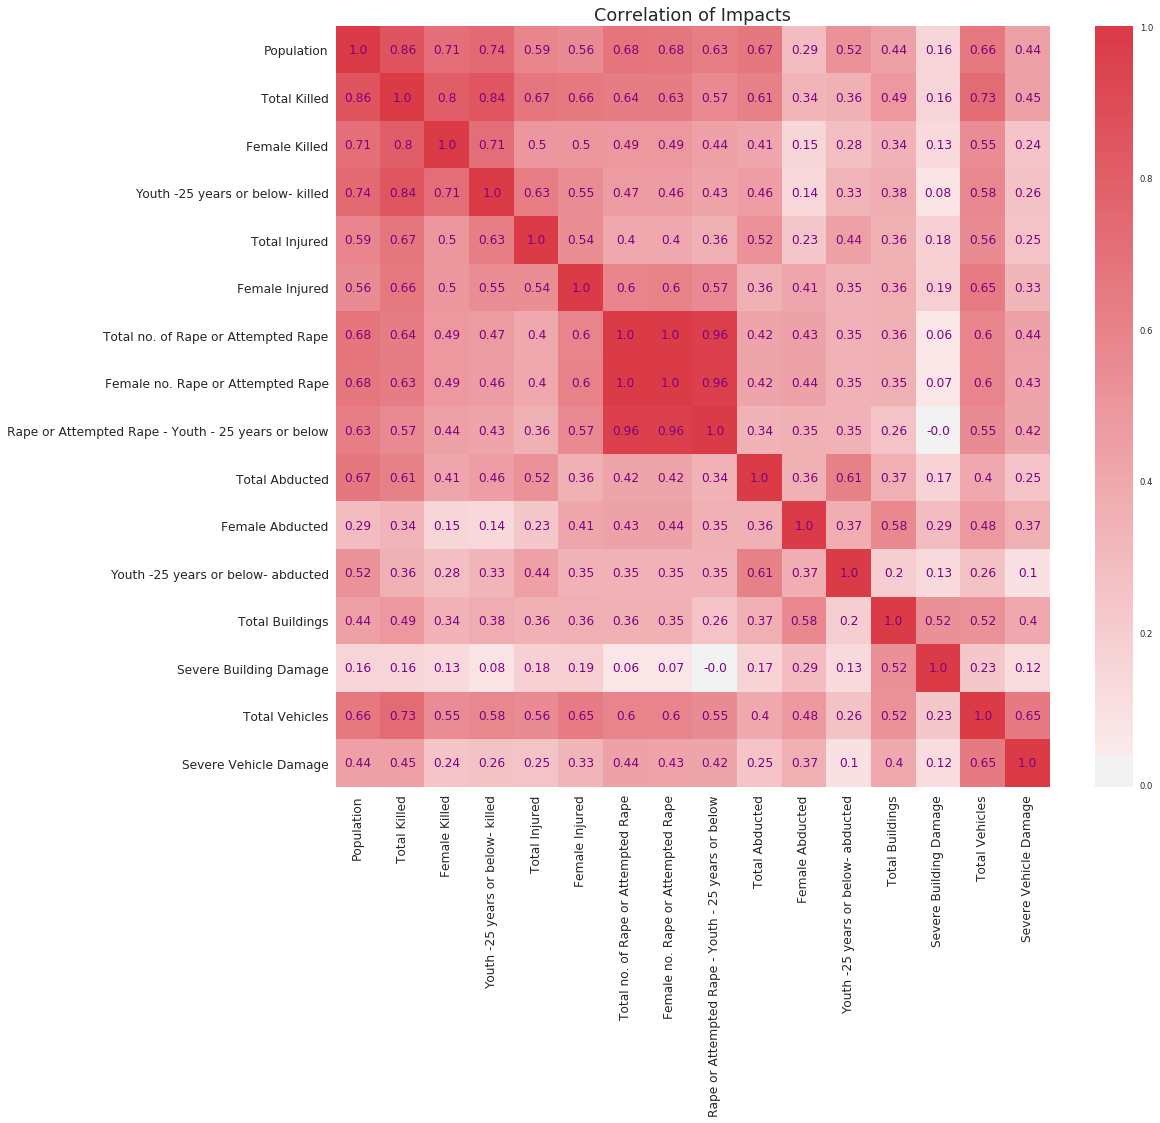

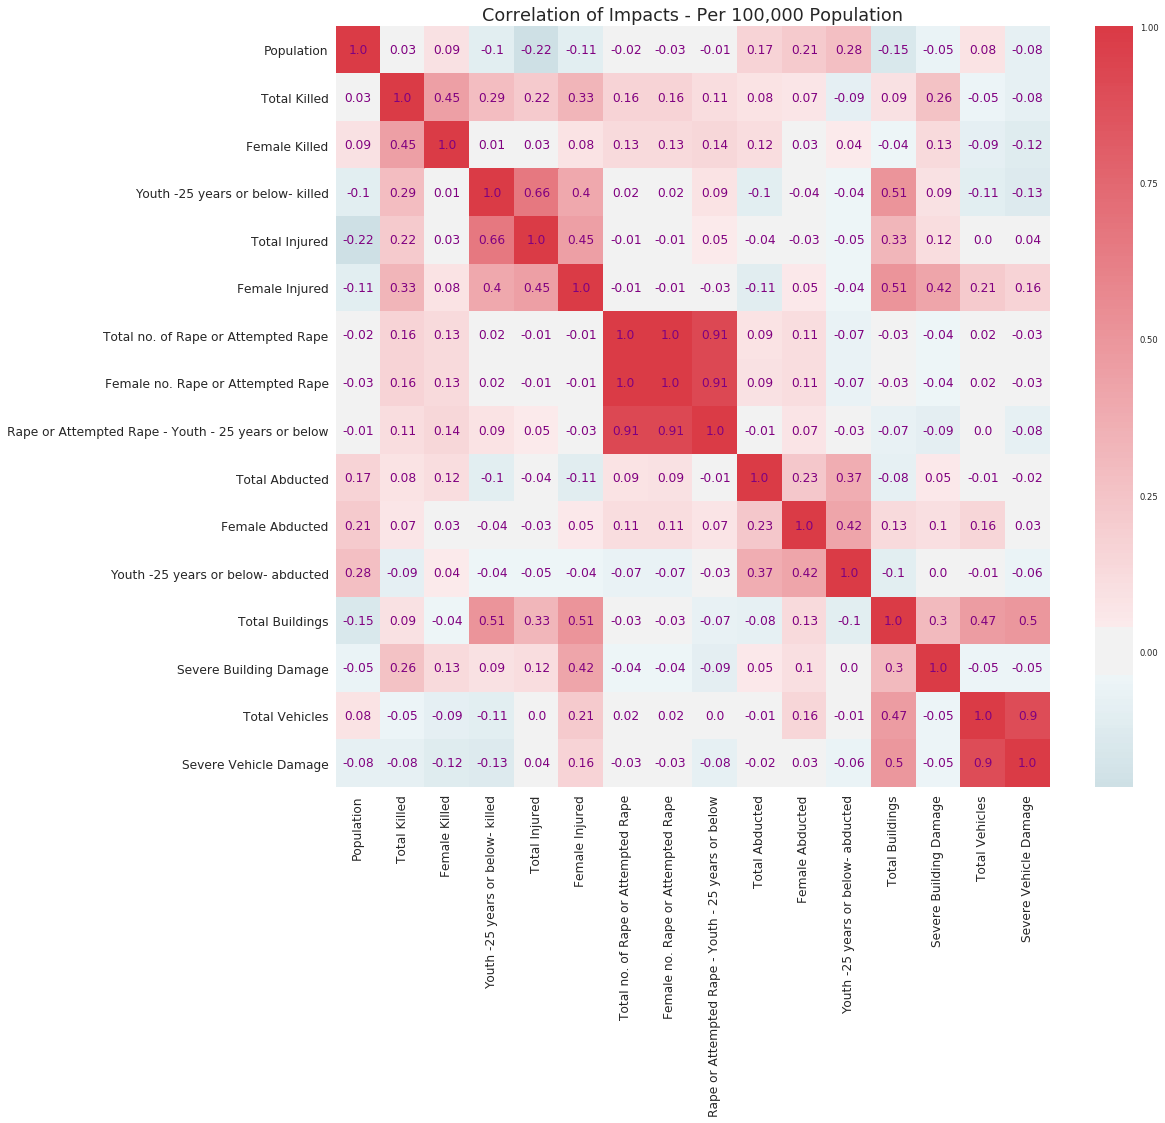

In [16]:
#Try some different seaborn plots to find relationships.  
import seaborn as sns #Do heat map? - probably need to add on more demographic information for the districts to do this well. 

def plotheat(df,title):
    corr = df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 14))
    
    
    
    #set title
    ax.set_title(title, fontsize='xx-large')
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    #create heatmap.
    hm = sns.heatmap(corr, cmap=cmap, center=0)
    #print(corr.head())
    
    plt.xticks(fontsize='large')
    plt.yticks(fontsize='large')
    #label with pearson values
    for row in range(0,corr.shape[0]):
        for column in range(0,corr.shape[1]):
            hm.text(column+0.5, row+0.5, round(corr.iloc[column][row],2), horizontalalignment='center', verticalalignment='center', size='large', color='purple')
    plt.show()

imdist_pop_no_prov = imdist_pop.drop('Province', axis=1)
plotheat(imdist_pop_no_prov,'Correlation of Impacts')
plotheat(imdist_normalized, 'Correlation of Impacts - Per 100,000 Population')

A correlation heatmap of all impacts shows a slight correlation between nearly all impacts, save for severe building damage. This could be a function of these impacts being correlated with population. The highest correlation with population appears to be "Total Killed."

Controlling for population by re-mapping impact numbers per 100,000 people reveals some interesting hot-spots. Some correlations between impacts are obvious, as they reflect overlapping events. For example, "Female Killed" is a subset of "Total Killed" so both should be correlated with each other. The same applies for "Total injured" v. "Female Injured" etc. Total killed numbers still show slight correlations with most other impacts, even when controlling for population, including injuries, rapes, abductions, and building damage. This may be a result of multiple impacts resulting from the same major events, but perhaps also shows there are some commonalities beyond population numbers which might predict where violence takes place. Incorporating other demographic information could be informative.

Other interesting correlations in the population normalized heat map: 
- Total/Female Injured and Total Buildings damaged (pearsonr = 0.51).
- Total Buildings and Total Vehicles (pearsonr = 0.47) 
- Population and abductions (pearsonr = .17 -.28 despite normalization)
- Negative correlation between population and injuries per capita (pearsonr = -0.22)
- Higher correlation between Total Injured and Youth - below 25 - Killed (0.66) than Female Killed and Total Killed (0.45)


## Are there significant differences in trends between provinces that can be shown?

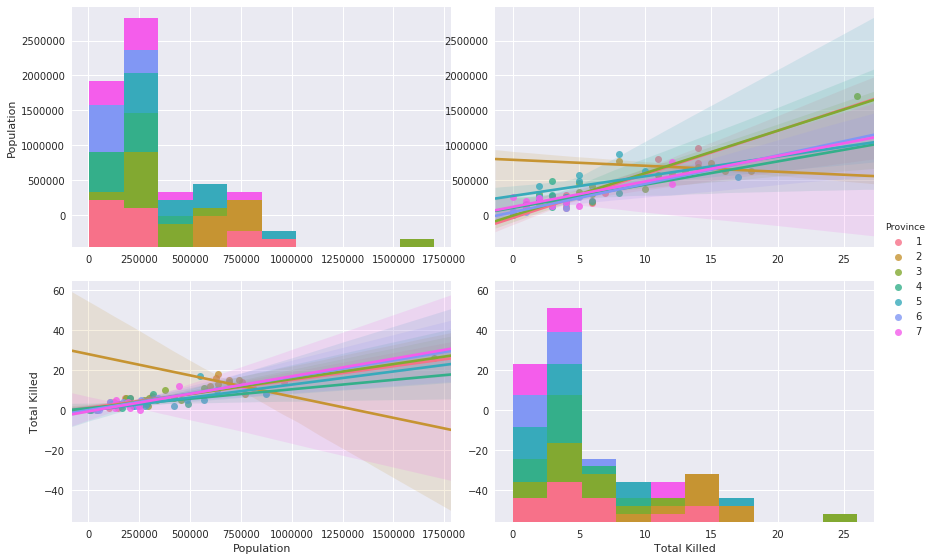

In [17]:
#try pairplot for the df
#malefemaledf = imdist_pop[['Province','Population','Total Killed','Female Killed']]
sns.set(font_scale=1)
sns.set_style()
sns.pairplot(imdist_pop, kind='reg', hue='Province', vars=['Population','Total Killed'],size=4, aspect=1.5)
#plt.xticks(rotation=60)
sns.despine()
plt.show()

In the pair plot above, we can see that most provinces more or less display a trend line correlating total killed with population. Province 2, however, displays a prominently different trend line. The reason for this is illuminated in the graph below. (Note: Re-plot this as a regplot with a hue by province) Use a less jaring color pallete.)

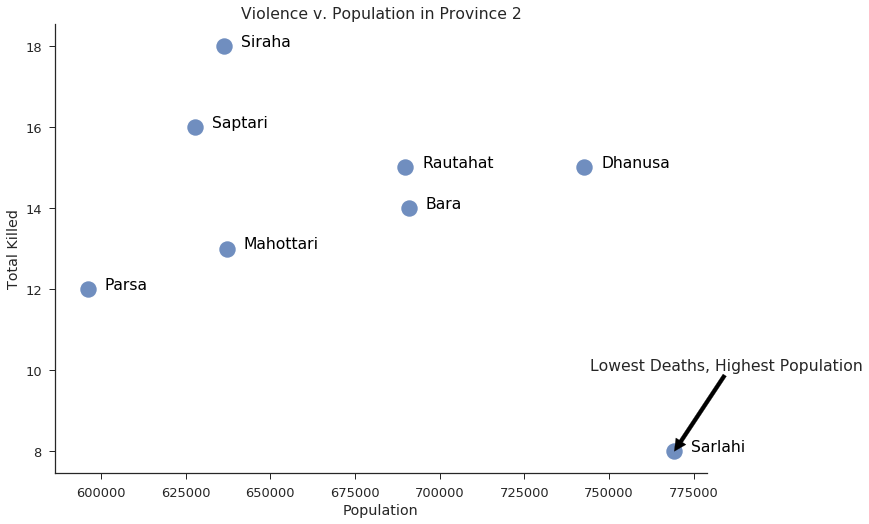

In [18]:
#Province 2 looks like an outlier for total killed in political violence. Let's plot it
im_province2 = imdist_pop.loc[imdist_pop['Province'] == 2].reset_index()
#sns.barplot(y="District", x="Total Killed", data=im_province2, label="Deaths by Political Violence in Provice 2", color="b")
#sns.despine()
#plt.show()
#sns.barplot(y="District", x="Population", data=im_province2, label="Population by District", color="y")
#sns.despine()
#plt.show()
sns.set(font_scale=1.3)
#sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots()
ax.set_title("Violence v. Population in Province 2")
fig.set_size_inches(11.69, 8.25)
p1 = sns.regplot(x="Population", y="Total Killed", data=im_province2, fit_reg=False, scatter_kws={"s": 270})

#label districts
for row in range(0,im_province2.shape[0]):
    ycorrect = 0
    #if im_province2.District[row] == 'Bara':
        #ycorrect = 0.5
    p1.text(im_province2.Population[row]+5000, im_province2['Total Killed'][row]-ycorrect, im_province2.District[row], horizontalalignment='left', size='medium', color='black')

sns.despine()#take off the top borders

#annotate with arrow
yloc=im_province2['Total Killed'].loc[im_province2.District == 'Sarlahi']
xloc=im_province2['Population'].loc[im_province2.District == 'Sarlahi']
plt.annotate('Lowest Deaths, Highest Population', xy=(xloc,yloc), xytext=(xloc-25000,yloc+2) ,arrowprops=dict(facecolor='black'))
plt.show()

Sarlahi has seen the lowest total killed in 2017 while possessing the highest population. Whether Province 2 bucking the trend is the result of unusually low deaths in Sarlahi, or unusually high deaths in the others remains to be explored.

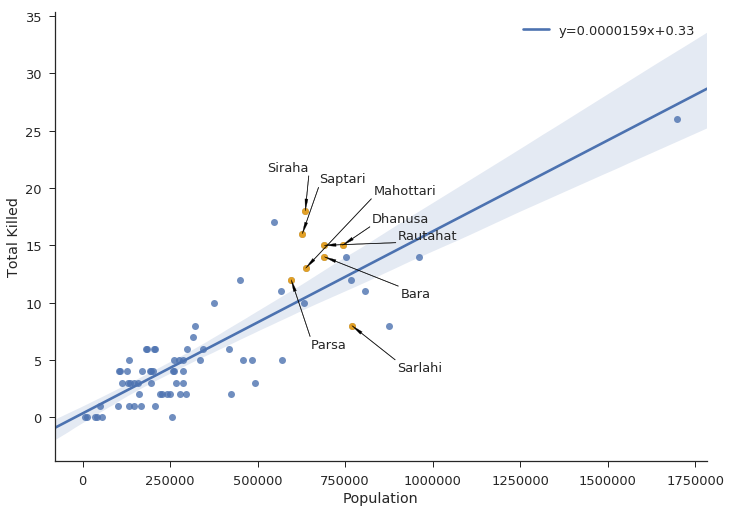

In [20]:
from scipy import stats

#create frame for just province 2
imdist_prov2 = imdist_pop.loc[imdist_pop.Province == 2]

#Plot population v totals deaths regression line and devation of province 2 districts from trend. 
fig, ax = plt.subplots()
fig.set_size_inches(11.69, 8.25)

# get coeffs of linear fit for legend. 
slope, intercept, r_value, p_value, std_err = stats.linregress(imdist_pop['Population'], imdist_pop['Total Killed'])
slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(imdist_prov2['Population'], imdist_prov2['Total Killed'])


#p3 = sns.FacetGrid(imdist_pop, hue="Province", size=10) \
 #  .map(plt.scatter, "Population", "Total Killed") 
p3 = sns.regplot(x='Population', y='Total Killed', data=imdist_pop, line_kws={'label':"y={0:.7f}x+{1:.2f}".format(slope,intercept)})
p3 = sns.regplot(x='Population', y='Total Killed', data=imdist_prov2, color='orange', fit_reg=False, truncate=True, line_kws={'label':"y={0:.7f}x+{1:.1f}".format(slope2,intercept2)})


#Plot anotother regression line over the same graph


#check for overlap of annotations
def checkoverlap(xpos,ypos,poscopy,text):
   
    up = 0.0
    over = 0
    xoffset = len(text)*5000
    #yoffset = .6
    xoff = xpos + xoffset
    #ypos += yoffset
    #print(poslist)
    xbuff = xoffset*2
    ybuff = 1.1
    for x, y in poscopy:
        #print(x,y)
        xdist = x-xoff
        ydist = y-ypos
        if (xdist + xoffset) != 0:
            if (abs(xdist) < xbuff) and (abs(ydist) < ybuff):
                #return True
                #if ydist != 0:
                up +=  ydist - up
                #if xdist != 0:
                over +=  xdist - over
                #print('Overlap:',' x=',x,'y=',y,'xpos=',xpos,'ypos=',ypos,'\n','xdist=',xdist,'ydist=',ydist,'xbuff=',xbuff,'ybuff=',ybuff,'up=',up,'over=',over)
                #up += upoff
                #over += overoff
    return tuple([up,over])
    
#label districts
def label_districts(poslist,districts):
    done = False
    count = 0
    while done == False:
        done = True
        poscopy = poslist
        for dist in districts:
            lst = districts[dist]
            comp = tuple([lst[0], lst[1]])
            app = tuple([lst[2], lst[3]])
            if comp != app:
                #print(dist, app)
                poscopy.append(app)
        for text in districts:
            #print(text)
            lst = districts[text]
            #print(lst)
            xpos = lst[0]
            ypos = lst[1]
            xloc = lst[2]
            yloc = lst[3]
            disp = checkoverlap(xloc,yloc,poscopy,text)
            dispy = disp[0]
            dispx = disp[1]
            if (dispy != 0) or (dispx != 0):
                count += 1
                done = False
                #print('Moving',text,':',dispy,dispx)
                #print(poslist[-5:])
                if (yloc < 0) or (count > 50):
                    yloc = yloc + .5
                else:
                    yloc = yloc - dispy
                if xloc < 0:
                    xloc = xloc + 10000
                else:
                    xloc = xloc - dispx
                districts[text] = [xpos,ypos,xloc,yloc]
            
    for text in districts:       
        lst = districts[text]
        #print(text,lst)
        xpos = lst[0]
        ypos = lst[1]
        xloc = lst[2]
        yloc = lst[3]
        if (xpos == xloc) and (ypos == yloc):
            p3.text(xpos+10000, ypos, text, horizontalalignment='left', size='small', color='black')
        else:
            plt.annotate(text, xy=(xpos,ypos), xytext=(xloc,yloc), arrowprops=dict(facecolor='black', width=0.5, headwidth=3), size='small')
    #poslist.append(tuple([xpos,ypos]))
    #return districts 

#poplulate poslist with the dots
poslist = [tuple([-1,-1])]
for row in imdist_pop.index:
    x = imdist_pop.Population[row]
    y = imdist_pop['Total Killed'][row]
    poslist.append(tuple([x,y]))
#print(poslist)

districts = {}    
for row in range(0,imdist_pop.shape[0]):
    if imdist_pop.Province[row] == 2:
        text = imdist_pop.index[row]
        ypos = imdist_pop['Total Killed'][row]
        xpos = imdist_pop['Population'][row]
        districts[text] = [xpos,ypos,xpos,ypos]
label_districts(poslist,districts)

sns.despine()#take off the top borders

# plot legend
ax.legend()

#show it
plt.show()

We can see the reason for Province 2 bucking the trend is two fold: Sarlahi has far fewer violent deaths per-capita than the linear regression line (1.59 deaths per 100,000 people +.33), while Parsa, Saptari, Siraha, and Rautahat have considerably more.

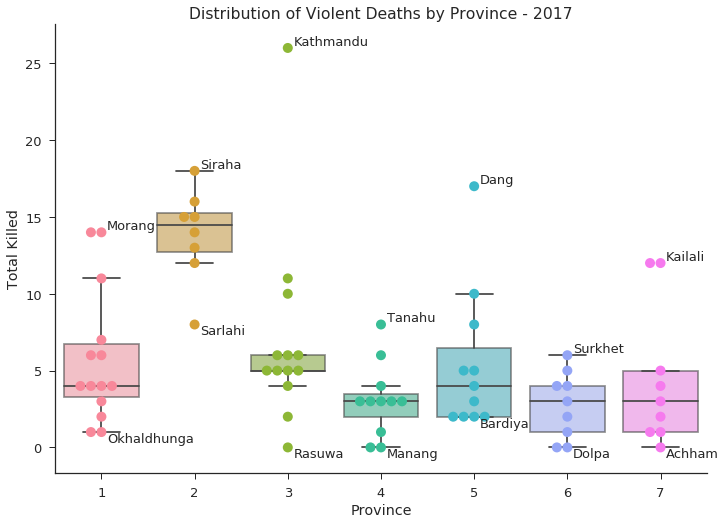

In [21]:
#Box Plots overlayed with swarm plots., 
def boxswarm(df,impact,title):
    fig, ax = plt.subplots()
    ax.set_title("Distribution of " + title + " by Province - 2017")
    fig.set_size_inches(11.69, 8.25)
    p1 = sns.swarmplot(x='Province', y=impact, data=df, size=10) #, jitter=True)

#Annotate max/min for province
    for p in range(1,8):
        im_prov = df.loc[df['Province'] == p]
        xpos = p-0.94
        ypos = max(im_prov[impact])
        text = im_prov.loc[im_prov[impact] == ypos].index[0]
        #p1.text(xpos, ypos+0.3, text, horizontalalignment='left', size='small', color='black') #need to get y correct from axis 
        plt.annotate(text, xy=(xpos,ypos), xytext=(0,+3), textcoords='offset points', fontsize='small')
        ypos = min(im_prov[impact])
        text = im_prov.loc[im_prov[impact] == ypos].index[0]
        #p1.text(xpos, ypos-1, text, horizontalalignment='left', size='small', color='black')
        plt.annotate(text, xy=(xpos,ypos), xytext=(0,-10), textcoords='offset points', fontsize='small')

    sns.boxplot(x='Province', y=impact, data=df, boxprops=dict(alpha=.6))
    
    sns.despine()
    plt.show()

boxswarm(imdist_pop,'Total Killed','Violent Deaths')

The the box plot above visualizes the distribution of violent deaths over federal provinces.  Each dot in the overlaid swarm plot represents a district, with it's vertical position indicating the 'Total Killed' in that district. Each province is plotted separately, by the province number, with the leading districts for each labeled. 

It is immediately apparent that province 2 has a tight  distribution of violent deaths per district, at a higher level than others with a similarly tight distribution. However,  districts of provinces with a wider distribution (1, 3, and 5) exceed the maximum deaths in province 2 by a wide margin. 

It is also clear that Kathmandu district not only exceeds the deaths in all other districts, but that it is an outlier for province 3, as it is well beyond the "whiskers" of the box plot.  We can also see from the previous regression plot that Kathmandu is also an outlier in terms of being well below the trend line of violent deaths per 100,000 people. This could mean that dropping Kathmandu from the data set could improve it's predictive power for the rest of Nepal.


In [22]:
#put the Provinces back in imdist normalized
prov_only = pop_pd.drop('Population', axis=1)
imdist_pop_normalized = prov_only.join(imdist_normalized)
imdist_pop_normalized = imdist_pop_normalized.drop('Population', axis=1)
imdist_pop_normalized.head()

,Province,Total Killed,Female Killed,Youth -25 years or below- killed,Total Injured,Female Injured,Total no. of Rape or Attempted Rape,Female no. Rape or Attempted Rape,Rape or Attempted Rape - Youth - 25 years or below,Total Abducted,Female Abducted,Youth -25 years or below- abducted,Total Buildings,Severe Building Damage,Total Vehicles,Severe Vehicle Damage
District,,,,,,,,,,,,,,,,
Achham,7,0.000000,0.000000,0.000000,8.587444,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Arghakhanchi,5,1.523647,1.015765,0.507882,2.031529,0.507882,1.015765,1.015765,1.015765,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Baglung,4,1.537829,0.768914,0.000000,0.768914,0.000000,0.384457,0.384457,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.384457,0.0
Baitadi,7,0.799281,0.799281,0.399640,3.197123,0.799281,1.598561,1.598561,0.799281,0.0,0.0,0.0,0.799281,0.799281,0.000000,0.0
Bajhang,7,2.054432,1.027216,0.513608,29.275659,0.513608,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


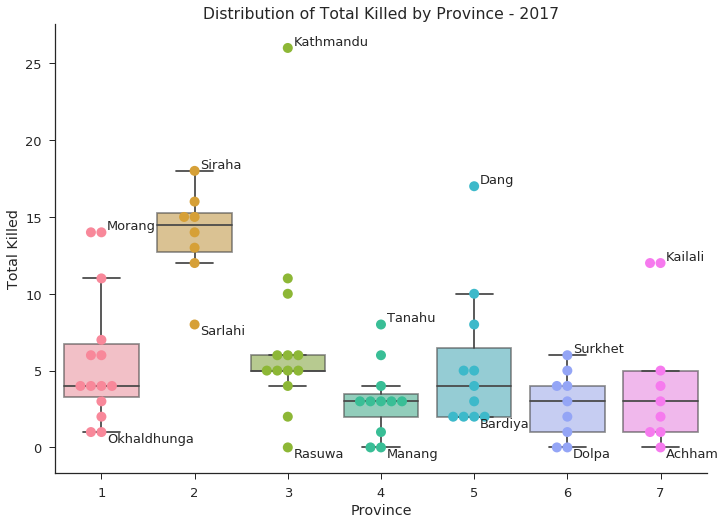

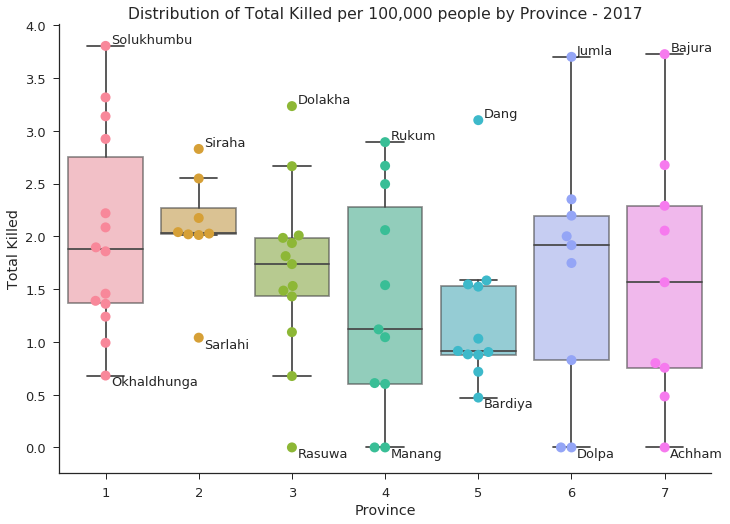

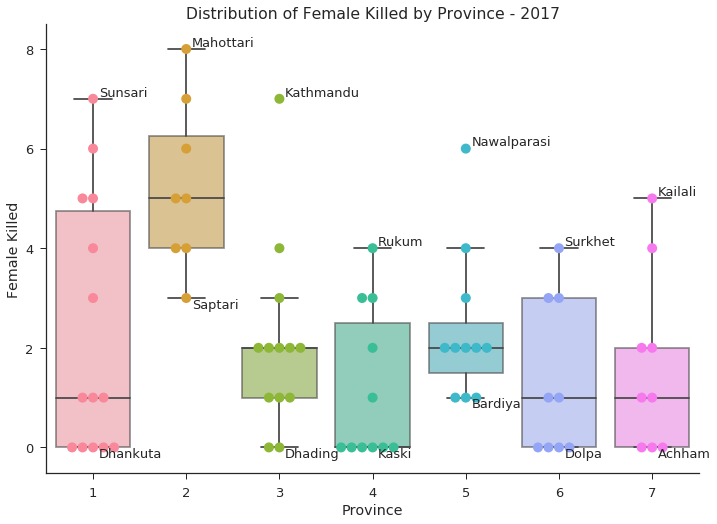

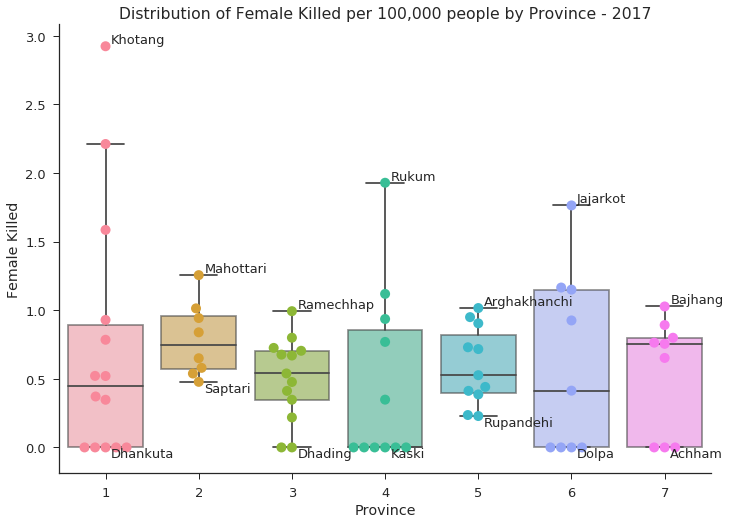

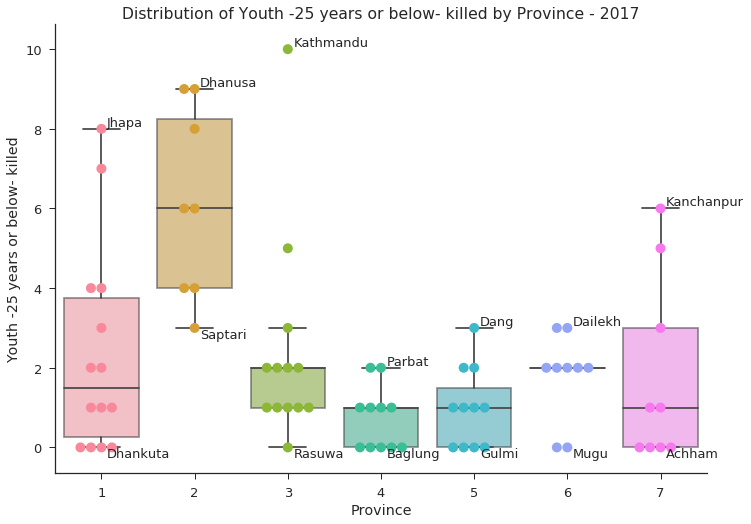

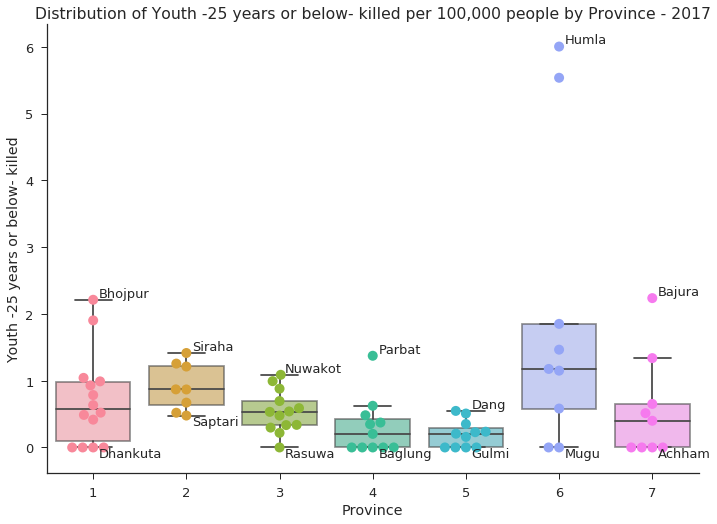

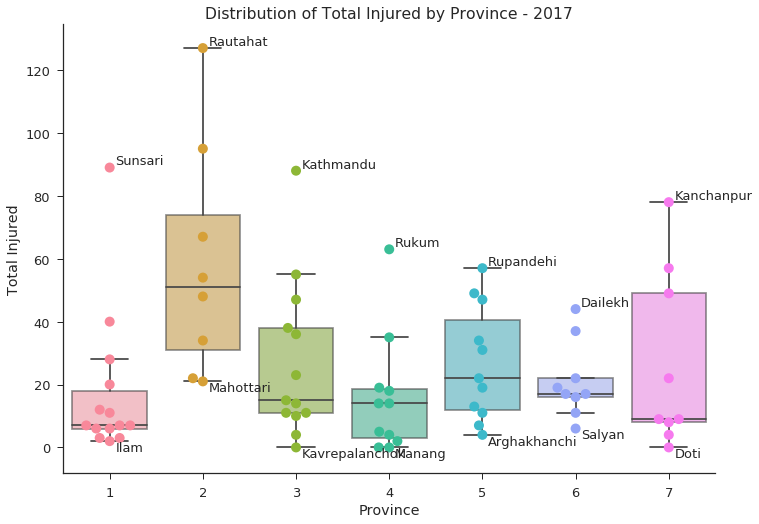

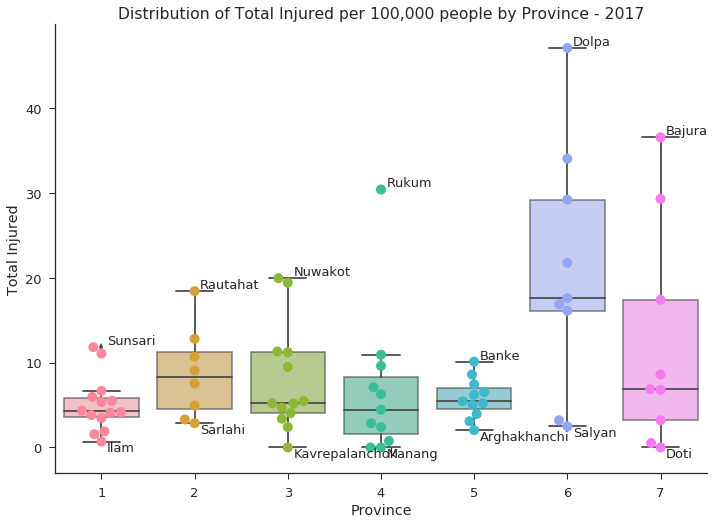

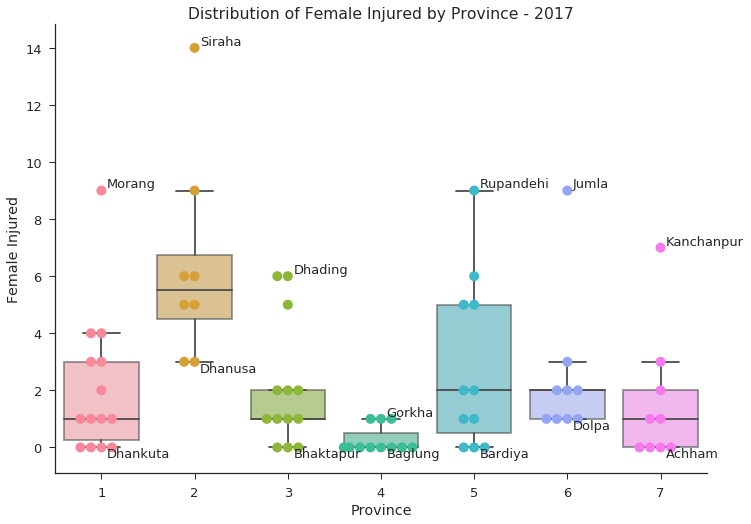

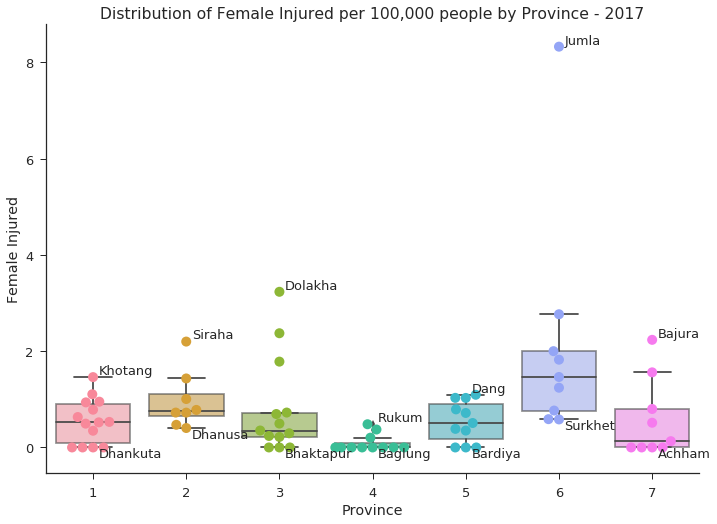

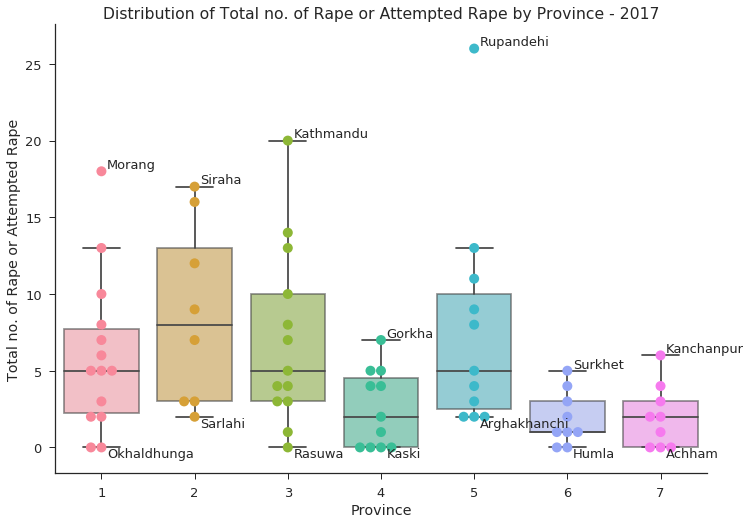

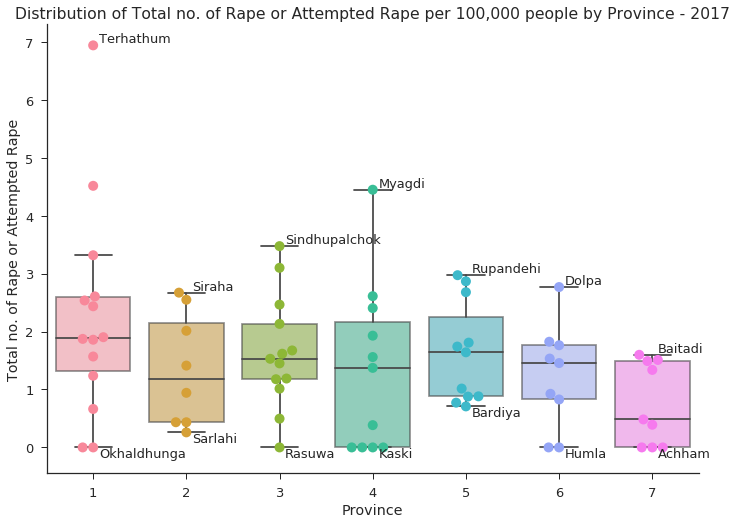

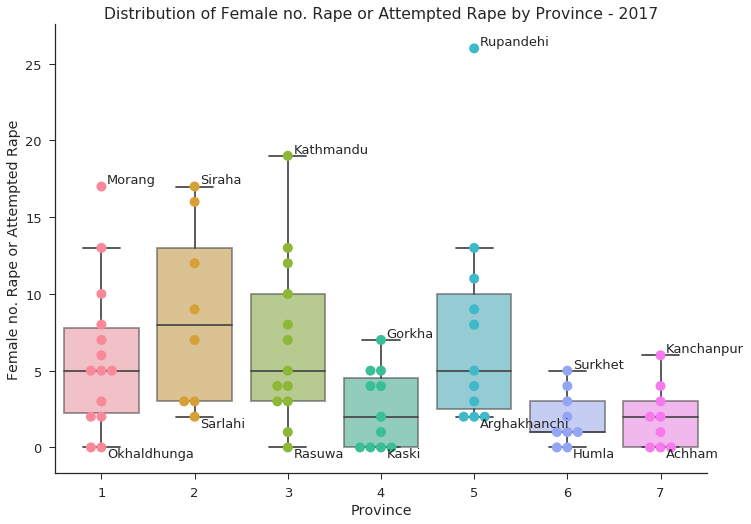

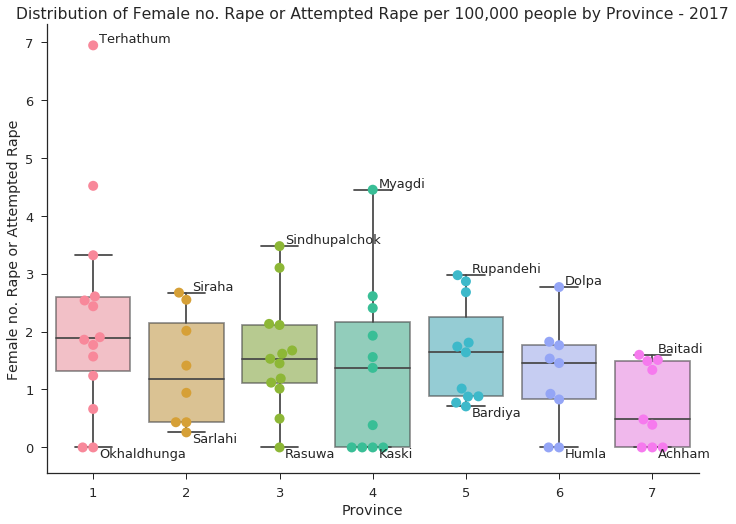

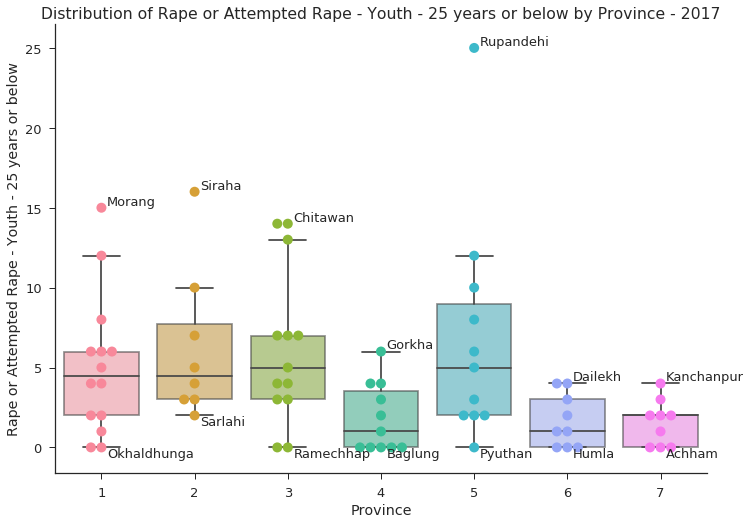

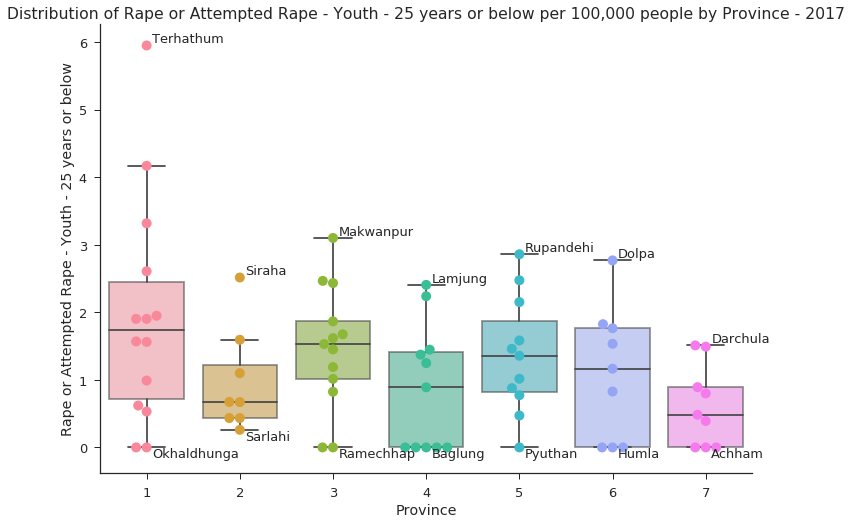

In [23]:
#Now let's plot the rest!
for impact in imdist_pop.columns[2:-7]:
    boxswarm(imdist_pop,impact,impact)  
    boxswarm(imdist_pop_normalized,impact,impact+' per 100,000 people')

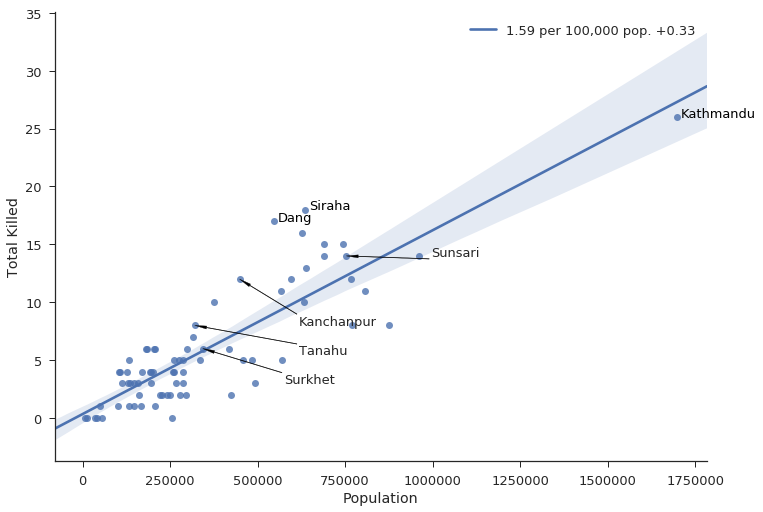

In [24]:
#Regplot that lables max and min values from above.
from scipy import stats

#Plot population v totals deaths regression line and devation of province 2 districts from trend. 
fig, ax = plt.subplots()
fig.set_size_inches(11.69, 8.25)

# get coeffs of linear fit for legend. 
slope, intercept, r_value, p_value, std_err = stats.linregress(imdist_pop['Population'], imdist_pop['Total Killed'])

#p3 = sns.FacetGrid(imdist_pop, hue="Province", size=10) \
 #  .map(plt.scatter, "Population", "Total Killed") 
p3 = sns.regplot(x='Population', y='Total Killed', data=imdist_pop, line_kws={'label':"{0:.2f} per 100,000 pop. +{1:.2f}".format(slope*100000,intercept) })#line_kws={'label':"y={0:.6f}x+{1:.1f}".format(slope,intercept)})
                                                                    #line_kws={'label':"y={0:.6f}x+{1:.1f}".format(slope,intercept)})

def postext(ypos,poslist):
    for text in im_prov.loc[im_prov['Total Killed'] == ypos].index:
        xpos = imdist_pop['Population'][text]
    districts[text] = [xpos,ypos,xpos,ypos]
    return districts

#poplulate poslist with the dots
poslist = [tuple([-1,-1])]
for row in imdist_pop.index:
    x = imdist_pop.Population[row]
    y = imdist_pop['Total Killed'][row]
    poslist.append(tuple([x,y]))
#print(poslist)
#label the max and min for each district
districts = {}
for p in range(1,8):
    im_prov = imdist_pop.loc[imdist_pop['Province'] == p]
    Killed = im_prov['Total Killed']
    ypos = max(Killed)
    districts = postext(ypos,districts)
    #ypos = min(Killed)
    #poslist = postext(ypos,poslist)
label_districts(poslist, districts)
    
sns.despine()#take off the top borders

# plot legend
ax.legend()

#show it
plt.show()

## To Do (prospective list):
* groupby VDC instead of district
* one-hot other incident values for subsequent 'groupby'
* Ask relivant questions / tell story with data.


## Conclusions

## Remaining Questions